In [2]:
from sage.all import *
import itertools as it
from random import shuffle
import numpy as np
from copy import copy, deepcopy
from dataclasses import dataclass
from typing import List


In [3]:
ring = PolynomialRing(QQ, ('x', 'y'), order='degrevlex')
x, y = ring.gens()

In [286]:
def border(O, span_variables=None):
    if span_variables is None:
        span_variables = O[0].args()

    B = []
    for x in span_variables:
        B += [x*o for o in O if x*o not in O]
    return sorted(list(set(B)), key=lambda t: t)

def terms_up_to_degree(d: int, ring):
    """Compute all terms up to degree d."""
    n = ring.ngens()
    terms = [ring(1)]
    for t in range(1, d+1):
        exponents = list(WeightedIntegerVectors(t, [1]*n))
        terms.extend([ring.monomial(*e) for e in exponents])
        
    terms = sorted(terms, key=lambda t: t)
    return terms

def order_from_border(B, ring):
    max_deg = max([b.degree() for b in B])
    terms = terms_up_to_degree(max_deg, ring)
    O = []
    for t in terms:
        if any([t.divides(b) for b in B if t != b]):
            O.append(t)
            
    return O

def subs(F, P):
    '''
    F: list of polynomials
    P: list of points
    '''
    field = P[0, 0].base_ring()
    num_polys  = len(F)
    num_points = P.nrows()
    
    FP = [f(*p) for f in F for p in P]

    return MatrixSpace(field, num_points, num_polys)(FP)

def is_regular(M):
    r = min(M.ncols(), M.nrows())
    return M.rank() == r

def keyword_for_numbound(field, bound):
    if field == QQ:
        return {'num_bound': bound}
    if field == ZZ:
        return {'x': -bound, 'y': bound}
    if field == RR:
        return {'min': -bound, 'max': bound}
    if field.is_finite():
        return {}
    

def is_all_divisors_in(t: Polynomial, O) -> bool:
    """
    Check if adding term t to order ideal O maintains the order ideal property.
    
    Since O is already an order ideal, we only need to check immediate divisors
    (reducing degree by 1 for each variable).
    """
    if t.degree() in (0, 1): 
        return True
    
    return all([xi in O and t/xi in O for xi in t.args() if xi.divides(t)])


def is_order_ideal(O):
    max_deg = max([o.degree() for o in O])
    
    if 1 not in O:
        return False
    
    O_ = [1]
    for d in range(1, max_deg+1):
        terms = [o for o in O if o.degree() == d]
        for t in terms:
            if not is_all_divisors_in(t, O_):
                return False
        
        O_ += terms
    
    return True
    
    

In [276]:
@dataclass
class Segment():
    endpoints: List  # two endpoints (n-dim vector each)
    axis: int  
    
    def __post_init__(self):
        self.lb = np.array(np.minimum.reduce(self.endpoints), dtype=int)
        self.ub = np.array(np.maximum.reduce(self.endpoints), dtype=int)
        self.n = len(self.lb)
    
    def __repr__(self):
        return f'Segment(lb={self.lb}, ub={self.ub}, endpoint={self.endpoints}, axis={self.axis})'

    def __hash__(self):
        return hash((tuple(self.lb), tuple(self.ub), self.axis))
    
    def sampling(self):
        # sample from the interior
        
        axis = self.axis
        point = self.ub 
        point[:axis] = np.random.randint(self.lb[:axis]+1, self.ub[:axis])  
        point[axis+1:] = np.random.randint(self.lb[axis+1:]+1, self.ub[axis+1:])
        return point
    
    def random_extention(self, length_bound):
        endpoint = self.sampling()
        print('new endpoint:', endpoint)
        endpoint[self.axis] = np.random.randint(1, length_bound+1)
        return Segment(deepcopy([self.lb, endpoint]), self.axis)
        
    def is_extendable(self):
        delta = np.abs(self.remove_axis(self.ub - self.lb))
        return all(delta >= 3)
    
    def remove_axis(self, v):
        return np.concatenate([v[:self.axis], v[self.axis+1:]])
        
    
@dataclass
class NeighborSegments():
    segments: List[Segment]
    intersecting_point: np.array
    
    def __post_init__(self):
        self.n = self.segments[0].n
        max_point = np.vstack([segment.ub for segment in self.segments])
        self.max_point = np.min(max_point + np.eye(self.n, dtype=int) * 100000, axis=0)
        self.valid = not np.any((self.max_point - self.intersecting_point) <= 1)
        
    def sampling(self):
        # print('sampling a point from')
        # print(self.intersecting_point, self.max_point)
        # assert(all(self.intersecting_point <= self.max_point))
        # regular_coordinates = self.intersecting_point + 1 < self.max_point
        
        degenerated = np.array(self.intersecting_point + 1 >= self.max_point, dtype=int)
        lb = self.intersecting_point
        ub = self.max_point
        point = np.random.randint(lb + 1, ub + degenerated)
        return point
    
    def split_at(self, splitpoint):
        
        # print(f'Random split for NeighborSegments (intersecting at {self.intersecting_point})')
        # for segment in self.segments:
        #     print(segment)
            
        # print(f'Sampled point {splitpoint}')
        
        new_neighborsegments = []
        for i in range(self.n):
            segment_i = Segment(deepcopy([self.intersecting_point, splitpoint]), i)
            new_segments = self.segments[:i] + [segment_i] + self.segments[i+1:]
            new_intersecting_point = self.intersecting_point + np.eye(self.n)[i] * splitpoint[i]
            new_neighborsegment = NeighborSegments(deepcopy(new_segments), new_intersecting_point)
            new_neighborsegments.append(new_neighborsegment)
        
        return new_neighborsegments
        
        


In [ ]:
import itertools as it
from random import shuffle
import numpy as np
from copy import copy, deepcopy
from dataclasses import dataclass
from typing import List

def min_but_max_at_i(a, b, i):
    lb = np.minimum(a, b)
    lb[i] = max(a[i], b[i])
    return lb 

def max_but_min_at_i(a, b, i):
    ub = np.maximum(a, b)
    ub[i] = min(a[i], b[i])
    return ub 

def is_on_axis(v):
    return np.sum(v != 0) <= 1


class BorderBasisGenerator():
    def __init__(self, ring): 
        self.ring = ring 
        self.n = ring.ngens()
    
    def find_border(self, degree_bounds, max_iters=100, preborder_size_limit=100):
        origin = np.zeros(self.n, dtype=int)
        max_point = np.array(degree_bounds)
        
        S = []
        for i in range(self.n):
            endpoint = max_point.copy()
            endpoint[i]= 0
            segment = Segment([origin, endpoint], i)
            S.append(segment)
            
        N = [NeighborSegments(deepcopy(S), origin)]
        T = []
        order_border = []
        for i in range(max_iters):
            
            # print('###################')
            # print(f'Iteration {i}')
            
            if i == max_iters - 1:
                print(f'Failed to find a border after {max_iters} iterations.')
                break
            if not N:
                print(f'No segments left to extend after {i} iterations.')
                break
            
            neighbor_segment = N.pop()
            
            new_neighborsegments = []
            splitpoint = neighbor_segment.sampling()
            if i == 0:
                order_border.extend(deepcopy(self.hypercube_points(origin, splitpoint, exclude_max=True)))
                
            for new_neighborsegment in neighbor_segment.split_at(splitpoint):
                if new_neighborsegment.valid:
                    # print('New neighbor segment:', new_neighborsegment)
                    new_neighborsegments.append(new_neighborsegment)
                # else:
                    # print('Invalid neighbor segment:', new_neighborsegment)
                T.append(new_neighborsegment)
                    
            N.extend(new_neighborsegments)
            
            shuffle(N)

        for neighbor_segment in T:
            u = neighbor_segment.intersecting_point
            v = neighbor_segment.max_point
            points = self.hypercube_points(u, v, exclude_max=True) # correponds to "+1" trick
            order_border.extend(deepcopy(points))

        order_border = list(set(order_border))
        # border = [np.array(endpoint) for endpoint in E if E[endpoint]]
        border = order_border
        # border = self.span_border(T)
        
        
        return border
        
    def hypercube_points(self, u, v, exclude_max=True):
        u = np.minimum(u, v)
        v = np.maximum(u, v)
        n = len(u)
        grid_ranges = [np.arange(u[i], v[i] + 1) for i in range(n)]
        points = [tuple(np.array(p)) for p in it.product(*grid_ranges) if not (exclude_max and np.array_equal(p, v))]
        
        return points
        
    
    def span_border(self, T: List[Segment]):
        
        for segment in T:
            faces = self.grid_points_on_max_faces(segment)
            # print(f'Grid points on the segment: {faces}')
            print(f'Grid points on the segment shape: {faces.shape}')
            
        
        return np.vstack([self.grid_points_on_max_faces(segment) for segment in T])
        

    def random_border(self, degree_bounds, **kwargs):
        
        upper_bounds = np.random.randint(1, np.array(degree_bounds)+1)
        print(f'Upper bounds: {upper_bounds}')
        
        return self.find_border(upper_bounds, **kwargs)
    
    
    def find_border_basis(self, B, O, P):
        ring = self.ring
        
        O = [ring(o) for o in O]
        OP = subs(O, P)
        if not is_regular(OP):
            print('The matrix is not regular.')
            return None, False
        
        B = [ring(b) for b in B]
        BP = subs(B, P)

        M = BP.augment(OP)
        V = M.transpose().kernel().basis()
        
        return V, True
    
    def random_border_basis(self, degree_bounds, max_sampling=100, degree_lower_bound=None, **kwargs):
        assert(len(degree_bounds) == self.n)
        
        if degree_lower_bound is None:
            degree_lower_bound = [0] * self.n
        
        ring = self.ring
        
        O = self.random_border(degree_bounds)  # order ideal and border 
        
        plot_border(degree_bounds, O)
        
        O = [ring.monomial(*o) for o in O]
        B = border(O)
        # OB = [ring.monomial(*b) for b in OB]
        # B = [ring.monomial(*b) for b in B]
        # O = order_from_border(B, ring)
        
        MSpace = MatrixSpace(ring.base_ring(), len(O), self.n)
        
        for i in range(max_sampling):
            if i == max_sampling - 1:
                print(f'Failed to find a border basis after {max_sampling} samping of points.')
                break
            P = MSpace.random_element(**keyword_for_numbound(ring.base_ring(), 10))
            V, success = self.find_border_basis(B, O, P)
            
            if success:
                break
        
        G = []
        for i in range(len(V)):
            g = B[i] - sum([v * o for v, o in zip(V[i][len(B):], O)])
            G.append(g)
        
        return {'basis': G,  'order_coeff': V, 'border': B, 'order': O, 'points': P, 'success': success}
    
        


In [293]:
%time
# seed = 1
# np.random.seed(seed)
# import random
# random.seed(seed)

ring = PolynomialRing(QQ, ('x', 'y', 'z'), order='degrevlex')
generator = BorderBasisGenerator(ring)

# dbounds = [10, 5, 25]
dbounds = [10, 10]
B = generator.find_border(dbounds)

# print(is_order_ideal([ring.monomial(*b) for b in B]))
print()
print('random border')
print(B)
# plot_border(dbounds, B)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [290]:
print(is_order_ideal([ring.monomial(*b) for b in B]))

True


In [269]:
%time
# seed = 1
# np.random.seed(seed)
# import random
# random.seed(seed)

ring = PolynomialRing(QQ, ('x', 'y'), order='degrevlex')
generator = BorderBasisGenerator(ring)

dbounds = [5, 1]
B = generator.find_border(dbounds)

print()
print('random border')
print(B)
plot_border(dbounds, B)

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 16.2 µs


ValueError: low >= high

Upper bounds: [2 1]
No segments left to extend after 1 iterations.


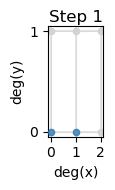

{'basis': [-50*x + y + 65, x*y - 43*x + 59, x^2 - 47*x + 56],
 'order_coeff': [
 (1, 0, 0, 50, -65),
 (0, 1, 0, 43, -59),
 (0, 0, 1, 47, -56)
 ],
 'border': [y, x*y, x^2],
 'order': [x, 1],
 'points': [ 4 -5]
 [ 3  5],
 'success': True}

In [237]:
generator.random_border_basis(dbounds, max_sampling=100)

In [120]:
is_order_ideal([ring.monomial(*b) for b in B])

True

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 13.4 µs
No segments left to extend after 1 iterations.

random border
[(1.0, 1.0, 0.0), (0.0, 1.0, 0.0), (0, 0, 0), (1.0, 0.0, 0.0), (2.0, 0.0, 0.0), (0.0, 0.0, 1.0)]


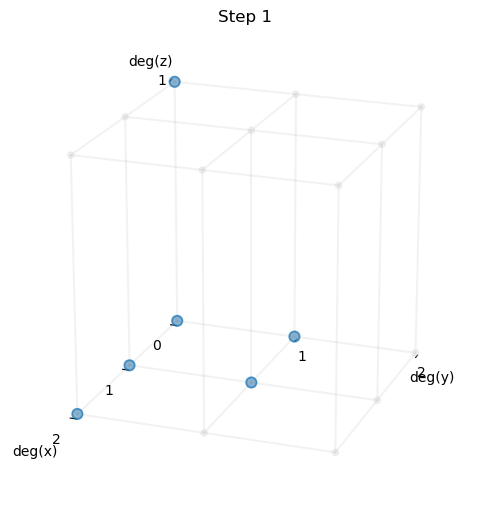

In [241]:
%time
# seed = 1
# np.random.seed(seed)
# import random
# random.seed(seed)

ring = PolynomialRing(QQ, ('x', 'y', 'z'), order='degrevlex')
generator = BorderBasisGenerator(ring)

dbounds = [2, 2, 1]
B = generator.find_border(dbounds)

print()
print('random border')
print(B)
plot_border_3d(dbounds, B)

segment picekd up: Segment(lb=[0 0 0], ub=[2 2 2], endpoint=[array([2, 0, 0]), array([0, 2, 0]), array([0, 0, 2])])
new endpoint: [2 1 2]
new segments:
Segment(lb=[2 0 0], ub=[2 1 2], endpoint=[array([2, 0, 0]), array([2, 1, 0]), array([2, 0, 2])])
--- accepted!
Segment(lb=[0 1 0], ub=[2 2 2], endpoint=[array([2, 1, 0]), array([0, 2, 0]), array([0, 1, 2])])
--- accepted!
Segment(lb=[0 0 2], ub=[2 1 2], endpoint=[array([2, 0, 2]), array([0, 1, 2]), array([0, 0, 2])])
--- accepted!
segment picekd up: Segment(lb=[2 0 0], ub=[2 1 2], endpoint=[array([2, 0, 0]), array([2, 1, 0]), array([2, 0, 2])])
--- rejected! [2 0 0]
new endpoint: [2 1 0]
new segments:
Segment(lb=[2 0 0], ub=[2 1 0], endpoint=[array([2, 0, 0]), array([2, 1, 0]), array([2, 0, 0])])
--- rejected! degenerated
--- rejected! on the same street
Segment(lb=[2 1 0], ub=[2 1 0], endpoint=[array([2, 1, 0]), array([2, 1, 0]), array([2, 1, 0])])
--- rejected! degenerated
Segment(lb=[2 0 0], ub=[2 1 2], endpoint=[array([2, 0, 0]), ar

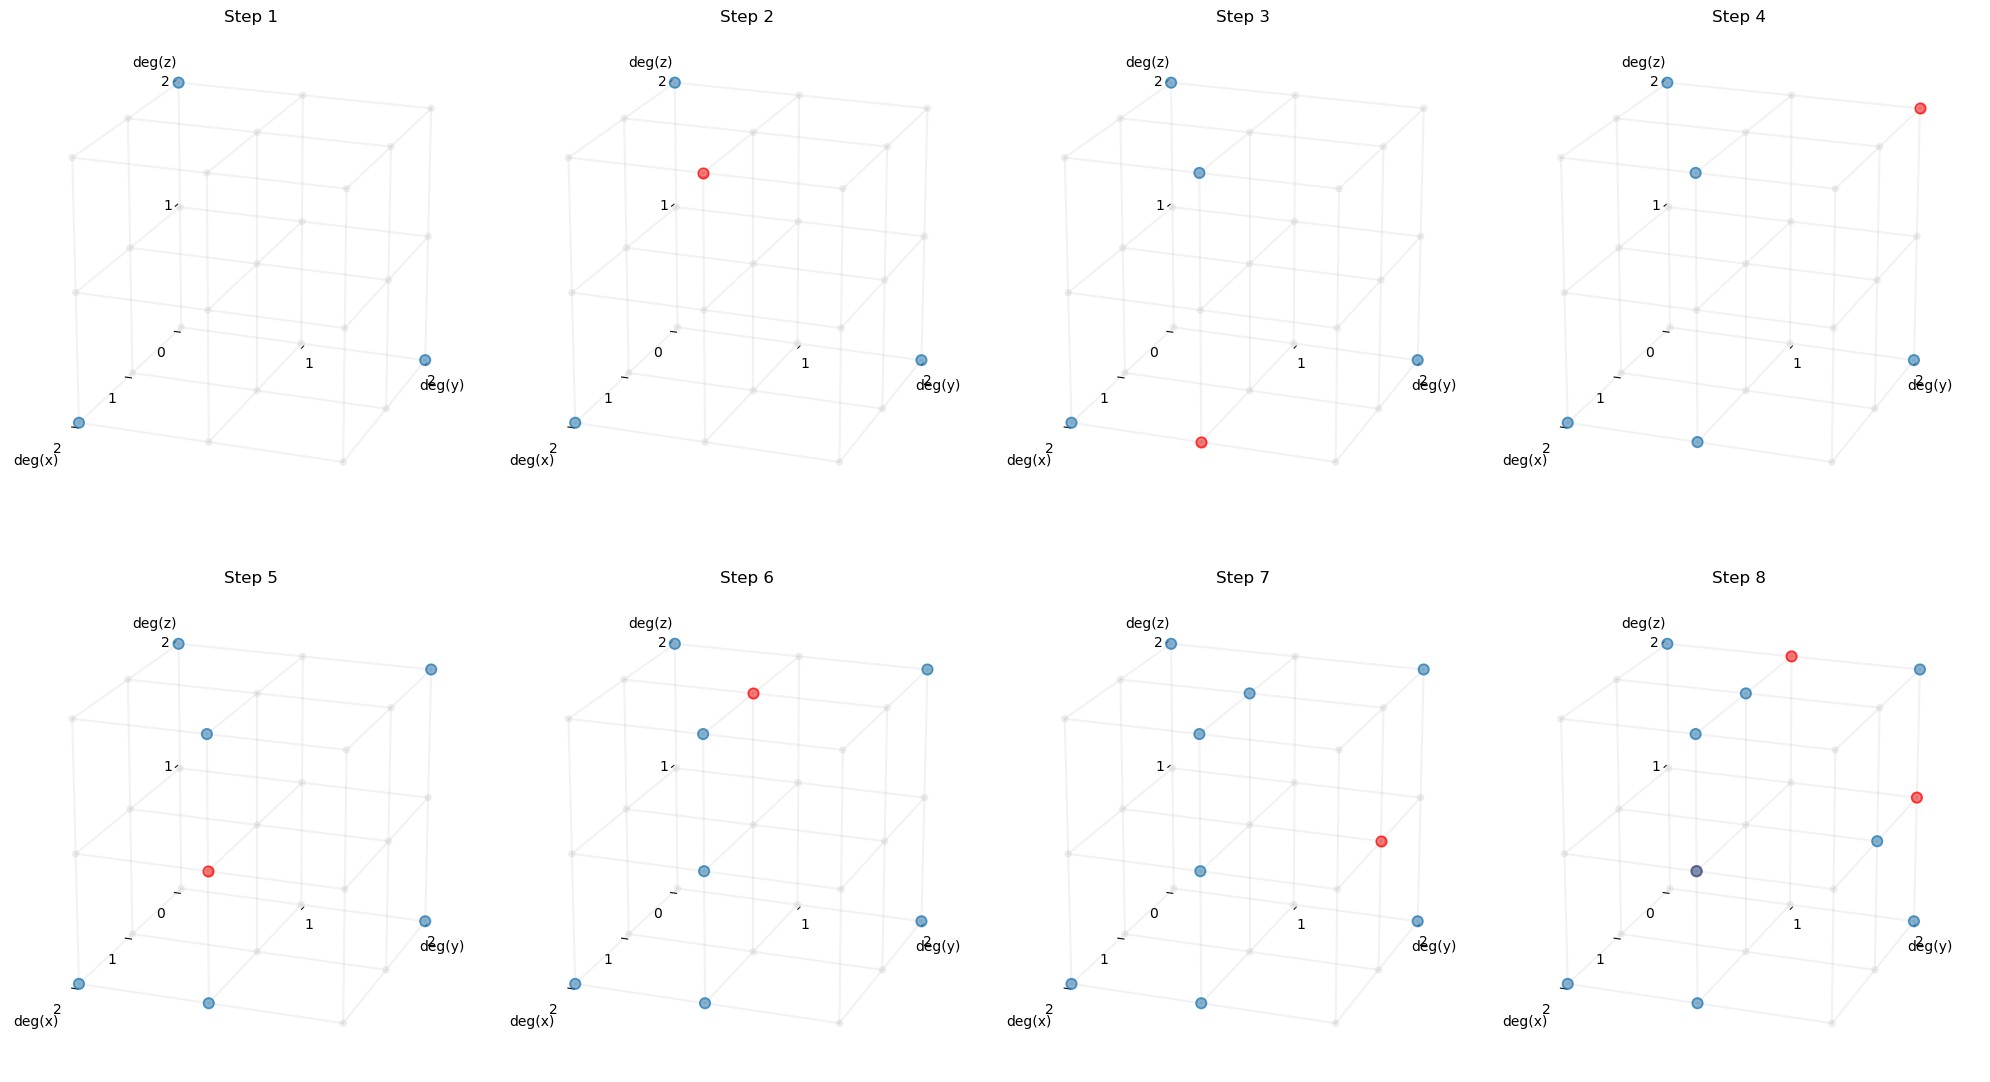

In [22]:
# fix random seed
seed = 5
np.random.seed(seed)
import random
random.seed(seed)


ring = PolynomialRing(QQ, ('x', 'y', 'z'), order='degrevlex')
generator = BorderBasisGenerator(ring)

dbounds = [2, 2, 2]
ret = generator.find_random_preborder(dbounds, max_iters=20)
Bs = ret['trajectory']
B = generator.close_border(Bs[-1])
Bs.append(B)
# # plot_borders(dbounds, Bs)
O = order_from_border([ring.monomial(*e) for e in B], ring)
# print(O)
plot_borders_3d(dbounds, Bs)

In [54]:
ret['segments']

[[array([2, 2, 1]), array([2, 0, 2]), array([1, 0, 1])],
 [array([2, 2, 0]), array([1, 2, 0]), array([2, 2, 2])],
 [array([2, 2, 1]), array([2, 0, 1]), array([0, 1, 1])],
 [array([1, 1, 2]), array([2, 1, 1]), array([0, 1, 2])],
 [array([2, 0, 0]), array([0, 0, 2]), array([2, 1, 1])],
 [array([2, 0, 0]), array([2, 2, 1]), array([2, 1, 2])],
 [array([1, 1, 2]), array([2, 2, 2]), array([2, 1, 0])],
 [array([0, 0, 2]), array([2, 1, 1]), array([0, 1, 2])],
 [array([2, 2, 1]), array([1, 0, 1]), array([1, 0, 2])],
 [array([2, 0, 0]), array([2, 0, 2]), array([2, 1, 2])],
 [array([0, 2, 0]), array([1, 1, 2]), array([1, 2, 2])],
 [array([0, 2, 0]), array([2, 0, 1]), array([0, 1, 1])],
 [array([1, 1, 2]), array([2, 2, 1]), array([1, 0, 2])],
 [array([1, 2, 0]), array([2, 2, 2]), array([2, 1, 0])],
 [array([1, 1, 2]), array([1, 2, 0]), array([2, 1, 0])],
 [array([2, 0, 0]), array([0, 2, 0]), array([2, 0, 1])]]

In [585]:
ret['segments']

[]

In [274]:
import matplotlib.pyplot as plt
import math

def plot_borders(degree_bounds, borders, filename=None):
    aspect_ratio = 1 # degree_bounds[0] / degree_bounds[1]
    
    n_plots = len(borders)
    n_cols = int(min(2 / aspect_ratio, n_plots))
    n_rows = math.ceil(n_plots / n_cols)
    
    fig = plt.figure(figsize=(3*n_cols, 2*n_rows))
    
    border_color = '#1f77b4'  # Steel blue
    
    for idx, border in enumerate(borders):
        ax = fig.add_subplot(n_rows, n_cols, idx+1)
        
        # Plot all points up to degree bounds
        points = [(i,j) for i in range(degree_bounds[0] + 1) 
                 for j in range(degree_bounds[1] + 1)]
        x_coords, y_coords = zip(*points)
        ax.scatter(x_coords, y_coords, c='lightgray', s=20, zorder=2)
        
        # Plot border points with blue color
        border_x, border_y = zip(*border)
        if idx == 0:
            ax.scatter(border_x, border_y, c=border_color, s=20, alpha=0.7, zorder=3)
        else:
            n = len(borders[idx-1])
            ax.scatter(border_x[:n], border_y[:n], c=border_color, s=20, alpha=0.7, zorder=3)
            ax.scatter(border_x[n:], border_y[n:], c='red', s=20, alpha=0.7, zorder=3)
        
        # Plot grid (with lower zorder)
        for i in range(degree_bounds[0] + 1):
            ax.axvline(i, color='gray', alpha=0.2, zorder=1)
        for i in range(degree_bounds[1] + 1):
            ax.axhline(i, color='gray', alpha=0.2, zorder=1)
        
        xticks = range(0, degree_bounds[0] + 1, max(1, degree_bounds[0] // 4))
        yticks = range(0, degree_bounds[1] + 1, max(1, degree_bounds[1] // 4))
        
        ax.set_xlabel('deg(x)')
        ax.set_ylabel('deg(y)')
        ax.grid(True, alpha=0.2, zorder=1)
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.set_title(f'Step {idx+1}', pad=3)
    
        ax.set_box_aspect(aspect_ratio)
        
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_border(degree_bounds, border, filename=None):
    plot_borders(degree_bounds, [border], filename)

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import numpy as np

def plot_borders_3d(degree_bounds, borders, filename=None):
    n_plots = len(borders)
    n_cols = int(min(4, n_plots))
    n_rows = math.ceil(n_plots / n_cols)
    
    fig = plt.figure(figsize=(5*n_cols, 6*n_rows))
    
    border_color = '#1f77b4'  # Steel blue
    
    for idx, border in enumerate(borders):
        ax = fig.add_subplot(n_rows, n_cols, idx+1, projection='3d')
        
        # グリッド線を追加
        for i in range(degree_bounds[0] + 1):
            for j in range(degree_bounds[1] + 1):
                ax.plot([i, i], [j, j], [0, degree_bounds[2]], 'gray', alpha=0.1)  # 垂直線

        for i in range(degree_bounds[0] + 1):
            for k in range(degree_bounds[2] + 1):
                ax.plot([i, i], [0, degree_bounds[1]], [k, k], 'gray', alpha=0.1)  # y方向の線

        for j in range(degree_bounds[1] + 1):
            for k in range(degree_bounds[2] + 1):
                ax.plot([0, degree_bounds[0]], [j, j], [k, k], 'gray', alpha=0.1)  # x方向の線
        
        # Plot all points up to degree bounds
        points = [(i,j,k) for i in range(degree_bounds[0] + 1) 
                         for j in range(degree_bounds[1] + 1)
                         for k in range(degree_bounds[2] + 1)]
        if points:
            x_coords, y_coords, z_coords = zip(*points)
            ax.scatter(x_coords, y_coords, z_coords, c='lightgray', s=20, alpha=0.3)
        
        # Plot border points with blue color
        border_x, border_y, border_z = zip(*border)
        if idx == 0:
            ax.scatter(border_x, border_y, border_z, c=border_color, s=60, alpha=0.7)
        else:
            n = len(borders[idx-1])
            ax.scatter(border_x[:n], border_y[:n], border_z[:n], c=border_color, s=60, alpha=0.7)
            ax.scatter(border_x[n:], border_y[n:], border_z[n:], c='red', s=60, alpha=0.7)
                
        # Set labels and ticks
        ax.zaxis.set_rotate_label(False)
        ax.set_xlabel('deg(x)')
        ax.set_ylabel('deg(y)')
        ax.set_zlabel('deg(z)', rotation=0)
        
        xticks = range(0, degree_bounds[0] + 1, max(1, degree_bounds[0] // 4))
        yticks = range(1, degree_bounds[1] + 1, max(1, degree_bounds[1] // 4))
        zticks = range(1, degree_bounds[2] + 1, max(1, degree_bounds[2] // 4))
        
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.set_zticks(zticks)
        
        ax.set_title(f'Step {idx+1}')
        
        # Set aspect ratio
        ax.set_box_aspect([1,1,1])
        
        # 平面のグリッドと背景色を消す
        ax.grid(False)  # グリッドを消す
        ax.xaxis.pane.fill = False  # x=0平面の塗りつぶしを消す
        ax.yaxis.pane.fill = False  # y=0平面の塗りつぶしを消す
        ax.zaxis.pane.fill = False  # z=0平面の塗りつぶしを消す

        # 平面の枠線も消したい場合
        ax.xaxis.pane.set_edgecolor('none')
        ax.yaxis.pane.set_edgecolor('none')
        ax.zaxis.pane.set_edgecolor('none')
        
        # 視点の設定
        ax.view_init(elev=20, azim=20)  # 標準的な等角投影の角度

        # Adjust view angle for better visibility
        ax.set_xlim(0, degree_bounds[0])  # x軸を反転（奥から手前へ）
        ax.set_ylim(0, degree_bounds[1])  # y軸は右向き
        ax.set_zlim(0, degree_bounds[2])  # z軸は上向き

        ax.xaxis._axinfo['juggled'] = (0,0,0)
        ax.yaxis._axinfo['juggled'] = (1,1,1)
        ax.zaxis._axinfo['juggled'] = (2,2,2)
        # ax.xaxis.set_ticks_position('top')  # x軸を奥に
        # ax.yaxis.set_ticks_position('default')  # y軸を右（奥）に
        # ax.zaxis.set_ticks_position('upper')    # z軸を上（奥）に

    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_border_3d(degree_bounds, border, filename=None):
    plot_borders_3d(degree_bounds, [border], filename)

# # 使用例
# if __name__ == "__main__":
    # サンプルデータ
# degree_bounds = (3, 3, 3)
# border = [(1,1,1), (2,1,1), (1,2,1), (1,1,2)]
# plot_border_3d(degree_bounds, border)

In [8]:
OP

NameError: name 'OP' is not defined

In [172]:
BP

[ 125   -8  1/8    8]
[   1    1  -25  -16]
[   0  -16 -1/2    1]
[   5  -32    0   32]
[ 1/4    1   -1  -64]
[   0  -64 -1/8    1]

In [84]:
# get random matrix with entries in ring.base_ring() and ranging from -5 ,5 
M = random_matrix(ring.base_ring(), 3, 3, x=-5, y=5)

TypeError: randomize() got an unexpected keyword argument 'x'

In [ ]:
import numpy as np
# P = np.random.randint(-5, 5, (len(O), 2))

FP = subs(O, P)
is_regular(FP)

True

In [76]:
BP = subs(B, P)
C = np.linalg.lstsq(FP, BP, rcond=None)[0]
C.shape

(6, 4)

In [ ]:
np.linalg.norm(BP - FP @ C)

5.352483649338326e-13